In [1]:
!pip install bar-chart-race==0.1.0

     |████████████████████████████████| 163kB 5.5MB/s 


In [2]:
# import modules and packages

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import bar_chart_race as bcr
import statsmodels.api as sm
import urllib.request
from fbprophet import Prophet
import json
import requests
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 60)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# define font and figure size of graph
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

In [4]:


user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'

url = 'https://covid19.ncdc.gov.ng/'
headers={'User-Agent':user_agent,} 

request=urllib.request.Request(url,None,headers) #The assembled request
response = urllib.request.urlopen(request)
data = response.read() # The data u need

In [5]:
time_series_data = 'https://raw.githubusercontent.com/ajakaiye33/covid19Naija/master/covid19Naija/data/Records_covid19.csv'
non_time_series_data = data

In [6]:
global_data = 'https://pomber.github.io/covid19/timeseries.json'

In [7]:
#Loading Data

def load_tm_data():
    #print('f Loading data from {filename} ...')
    df = pd.read_csv(time_series_data, parse_dates=['Dates'], index_col='Dates')
    print(f'shape of data {df.shape}')
    print(f'checking for missing values {df.info()}')
    return df

def load_ntm_data():
    #print(f'Loading data from .. {file_name}')
    df = pd.read_html(non_time_series_data)
    df = df[-1]
    # print(f'shape of data: {df.shape}')
    # print(f'checking for missing data: {df.info()}')
    return df

def naija_cases(url=global_data):
  time_series = str(url)
  response = requests.get(time_series)
    
  #function to check status of webpage
  def status_check(r):
    if r.status_code == 200:
      return 1
    else:
      return -1
  def encoding_check(r):
    return (r.encoding)
  def decode_content(r,encoding):
    return (r.content.decode(encoding))
  status = status_check(response)
  if status == 1:
    contents = decode_content(response,encoding_check(response))
  else:
    print('Sorry could not reach the web page!')
    return -1
  # load into pandas
  str_data = json.loads(contents)
  isolate_nig = str_data['Nigeria']
  pand_data = pd.DataFrame(isolate_nig)
  return pand_data

naija_data = naija_cases()

#deathby_state = pd.read_csv('data/cases27062020.csv')

In [9]:
naija_data['date'] = pd.to_datetime(naija_data['date'])
naija_data.tail()

,date,confirmed,deaths,recovered
346,2021-01-02,89163,1302,74789
347,2021-01-03,90080,1311,75044
348,2021-01-04,91351,1318,75699
349,2021-01-05,92705,1319,76396
350,2021-01-06,94369,1324,77299


In [10]:

covid_ng2 = load_ntm_data()
covid_ng2.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,32687,5100,27337,250
1,FCT,12428,4593,7731,104
2,Kaduna,5555,575,4926,54
3,Plateau,5174,398,4732,44
4,Oyo,4086,618,3416,52


In [11]:
#covid_ng = load_tm_data()

In [12]:
#format header columns
def clean_col(name):
    #print('pretifying the column names')
    pretify_name = name.strip().lower().replace(" ", "_").replace('/','_')
    return pretify_name


## clean columns
clean_covid_ng2 = covid_ng2.rename(columns=clean_col)
#clean_covid_ng = covid_ng.rename(columns=clean_col)
columns = {}
for col in clean_covid_ng2.columns:
    if col == 'abuja(fct)':
        columns['abuja(fct)'] = 'abuja'
    elif col == 'dealth':
        columns['dealth'] = 'deaths'
    elif col == 'dischared_revovered':
        columns['dischared_revovered'] = 'discharged_recovered'
clean_covid_ng2.rename(columns=columns, inplace=True)

In [13]:
clean_covid_ng2.head()

,states_affected,no._of_cases_(lab_confirmed),no._of_cases_(on_admission),no._discharged,no._of_deaths
0,Lagos,32687,5100,27337,250
1,FCT,12428,4593,7731,104
2,Kaduna,5555,575,4926,54
3,Plateau,5174,398,4732,44
4,Oyo,4086,618,3416,52


In [14]:
## see columns
clean_covid_ng2.iloc[:,0]

0           Lagos
1             FCT
2          Kaduna
3         Plateau
4             Oyo
5          Rivers
6             Edo
7            Ogun
8            Kano
9           Delta
10           Ondo
11        Katsina
12          Kwara
13          Enugu
14          Gombe
15         Ebonyi
16         Bauchi
17           Abia
18           Osun
19       Nasarawa
20          Borno
21            Imo
22        Bayelsa
23          Benue
24      Akwa Ibom
25        Adamawa
26         Sokoto
27          Ekiti
28          Niger
29         Jigawa
30        Anambra
31         Taraba
32           Yobe
33          Kebbi
34    Cross River
35        Zamfara
36           Kogi
Name: states_affected, dtype: object

In [15]:
pd.set_option('display.max_rows', 800)

In [16]:
second_data = covid_ng2
affected_column = ['no._of_cases_(lab_confirmed)', 'no._of_cases_(on_admission)','no._discharged']
def polish_data(df):
    clean_columns = df.rename(columns=clean_col)
    # for i in clean_columns.columns:
    #     if i in affected_column:
    #         clean_columns[i] = clean_columns[i].str.replace(',','').astype('int64')
    return clean_columns
melt_data = polish_data(second_data)
melt_data.head()

,states_affected,no._of_cases_(lab_confirmed),no._of_cases_(on_admission),no._discharged,no._of_deaths
0,Lagos,32687,5100,27337,250
1,FCT,12428,4593,7731,104
2,Kaduna,5555,575,4926,54
3,Plateau,5174,398,4732,44
4,Oyo,4086,618,3416,52


In [17]:
using_unstack = melt_data.pivot_table(values='no._of_cases_(lab_confirmed)',columns='states_affected')
using_unstack

states_affected,Abia,Adamawa,Akwa Ibom,Anambra,Bauchi,Bayelsa,Benue,Borno,Cross River,Delta,Ebonyi,Edo,Ekiti,Enugu,FCT,Gombe,Imo,Jigawa,Kaduna,Kano,Katsina,Kebbi,Kogi,Kwara,Lagos,Nasarawa,Niger,Ogun,Ondo,Osun,Oyo,Plateau,Rivers,Sokoto,Taraba,Yobe,Zamfara
no._of_cases_(lab_confirmed),1036,424,465,337,1052,545,537,808,169,1911,1120,2938,417,1420,12428,1359,769,407,5555,2367,1636,192,5,1495,32687,923,417,2564,1843,1022,4086,5174,3639,420,225,201,112


In [18]:
# working_data = melt_data.pivot(columns='states_affected', values='no._of_cases_(lab_confirmed)').fillna(0)

# working_data.head()

In [19]:
listy= using_unstack.columns.to_list()
for i,j in enumerate(listy):
  print(i,j)

0 Abia
1 Adamawa
2 Akwa Ibom
3 Anambra
4 Bauchi
5 Bayelsa
6 Benue
7 Borno
8 Cross River
9 Delta
10 Ebonyi
11 Edo
12 Ekiti
13 Enugu
14 FCT
15 Gombe
16 Imo
17 Jigawa
18 Kaduna
19 Kano
20 Katsina
21 Kebbi
22 Kogi
23 Kwara
24 Lagos
25 Nasarawa
26 Niger
27 Ogun
28 Ondo
29 Osun
30 Oyo
31 Plateau
32 Rivers
33 Sokoto
34 Taraba
35 Yobe
36 Zamfara


In [20]:
rough_copy = using_unstack.copy()
rough_copy.head()
# useful_variable = rough_copy.drop([list])

states_affected,Abia,Adamawa,Akwa Ibom,Anambra,Bauchi,Bayelsa,Benue,Borno,Cross River,Delta,Ebonyi,Edo,Ekiti,Enugu,FCT,Gombe,Imo,Jigawa,Kaduna,Kano,Katsina,Kebbi,Kogi,Kwara,Lagos,Nasarawa,Niger,Ogun,Ondo,Osun,Oyo,Plateau,Rivers,Sokoto,Taraba,Yobe,Zamfara
no._of_cases_(lab_confirmed),1036,424,465,337,1052,545,537,808,169,1911,1120,2938,417,1420,12428,1359,769,407,5555,2367,1636,192,5,1495,32687,923,417,2564,1843,1022,4086,5174,3639,420,225,201,112


In [21]:
def extract_zones(df):
  df['south_west'] = df['Lagos'] + df['Ondo'] + df['Osun'] + df['Oyo'] + df['Ekiti'] + df['Ogun']
  df['south_south'] = df['Edo'] + df['Rivers'] + df['Delta'] + df['Cross River'] + df['Bayelsa'] + df['Akwa Ibom']
  df['south_east'] = df['Anambra'] + df['Imo'] + df['Enugu'] + df['Abia'] + df['Ebonyi']
  df['north_central'] = df['Benue'] + df['Kogi'] + df['Nasarawa'] + df['Niger'] + df['Plateau'] + df['Kwara'] + df['FCT']
  df['north_east'] = df['Adamawa'] + df['Bauchi'] + df['Borno'] + df['Gombe'] + df['Taraba'] + df['Yobe']
  df['north_west'] = df['Jigawa'] + df['Kaduna'] + df['Kano'] + df['Katsina'] + df['Kebbi'] + df['Sokoto'] + df['Zamfara']
  df = df.drop(listy,1)

  #df = df[['south_south','south_west','south_east', 'north_central','north_west', 'north_east']]
  df = df.melt(value_vars=['south_west','south_south', 'south_east', 'north_central','north_east','north_west'],
                                 var_name='geopolitical_zones', value_name='confirmed_zone_cases')
  df = df.groupby('geopolitical_zones').agg({'confirmed_zone_cases': 'sum'}).reset_index()
  df =  df.sort_values('confirmed_zone_cases', ascending=False)
  return df

final_zones = extract_zones(using_unstack)
final_zones



,geopolitical_zones,confirmed_zone_cases
5,south_west,42619
0,north_central,20979
2,north_west,10689
4,south_south,9667
3,south_east,4682
1,north_east,4069


## Cases By Geopolitical Zones

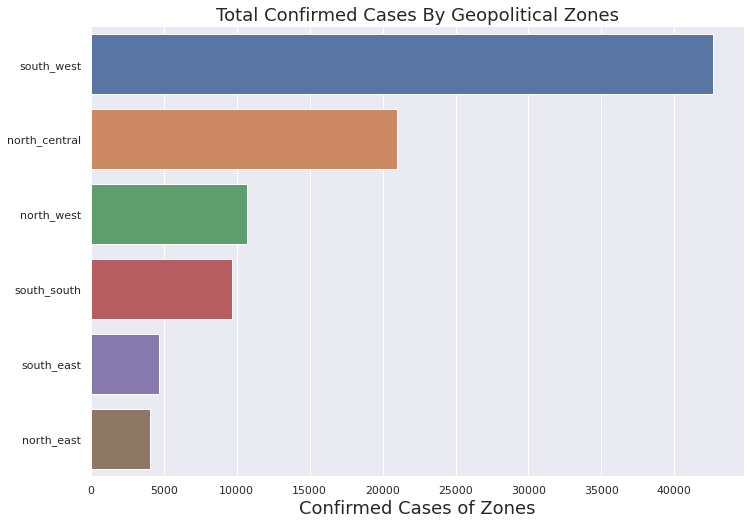

In [22]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='confirmed_zone_cases', y='geopolitical_zones', data=final_zones);
ax.set_title('Total Confirmed Cases By Geopolitical Zones', size = 18)
ax.set_xlabel('Confirmed Cases of Zones', size=18)
ax.set_ylabel('', size=18)
sns.despine(left=True)
plt.xticks(rotation=360)
plt.show()

## Medical Statistics

#### Case Fatality Rate(CFR)
$$\large CFR = \frac{Total Number of Death}{Total number Infected}$$

In [23]:
def case_fatality(df):
    df = df.set_index('date')
    df = df.diff()
    total_death = df['deaths'].sum()
    total_confirm_cases = df['confirmed'].sum()
    cfr = total_death/total_confirm_cases * 100
    return cfr
cfr = case_fatality(naija_data)

print(f'The Case Fatality rate In Nigeria is: {round(cfr,2)}%')

The Case Fatality rate In Nigeria is: 1.4%


#### Mortality Rate
$$\large MR = \frac{Total Population}{Total Deaths}$$ 
[Estimated population of Nigeria](https://en.wikipedia.org/wiki/Demographics_of_Nigeria): 200 Million

In [24]:
def mortality_rate(df):
    estimated_population = 200000000
    covid_deaths = df['deaths'].sum()
    mr = covid_deaths/estimated_population
    return mr
mr = mortality_rate(naija_data)
death_per1million = naija_data['deaths'].sum()/1000000
print(f'The Mortality Rate of Covid19: {mr}, whereas deaths per one million is:{death_per1million}')

The Mortality Rate of Covid19: 0.00110274, whereas deaths per one million is:0.220548


## Monthly Statistics

## Confirmed Cases By Month

In [26]:
def monthly_stats(df):
    
    df = df.set_index('date')
    df = df.diff()
    monthly_data = df.resample('M').agg({'deaths':'sum', 'confirmed':'sum','recovered':'sum'})
    monthly_data['date'] = monthly_data.index
    monthly_data['month'] = monthly_data['date'].dt.date
    return monthly_data.drop('date', axis=1)
df_month = monthly_stats(naija_data)
df_month.tail()


,deaths,confirmed,recovered,month
date,,,,
2020-09-30,99.0,4840.0,8720.0,2020-09-30
2020-10-31,32.0,4005.0,8317.0,2020-10-31
2020-11-30,29.0,4704.0,4607.0,2020-11-30
2020-12-31,116.0,20050.0,10431.0,2020-12-31
2021-01-31,35.0,6762.0,3586.0,2021-01-31


### Monthly Confirmed Cases

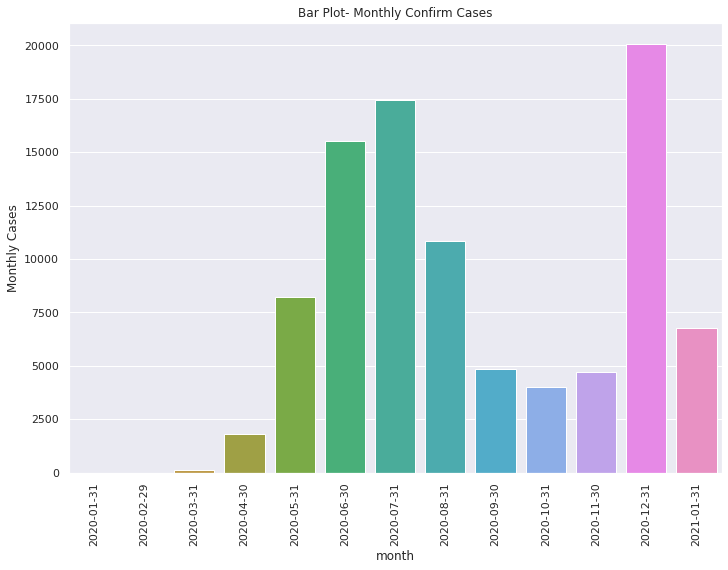

In [27]:
# Monthly confirmed cases
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='confirmed', data=df_month)
ax.set_title('Bar Plot- Monthly Confirm Cases')
ax.set_ylabel('Monthly Cases')
plt.xticks(rotation = 90)
plt.show()

## Deaths By Month

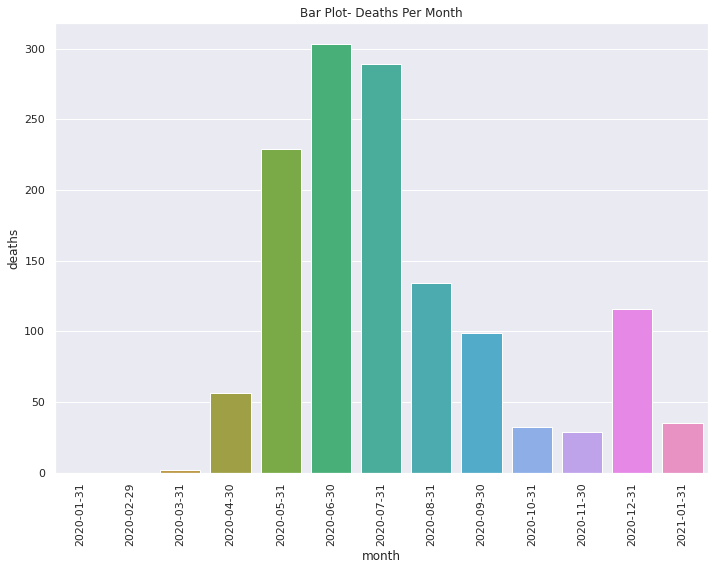

In [28]:
#Monthly Deaths
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='deaths', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## Recoveries By Month

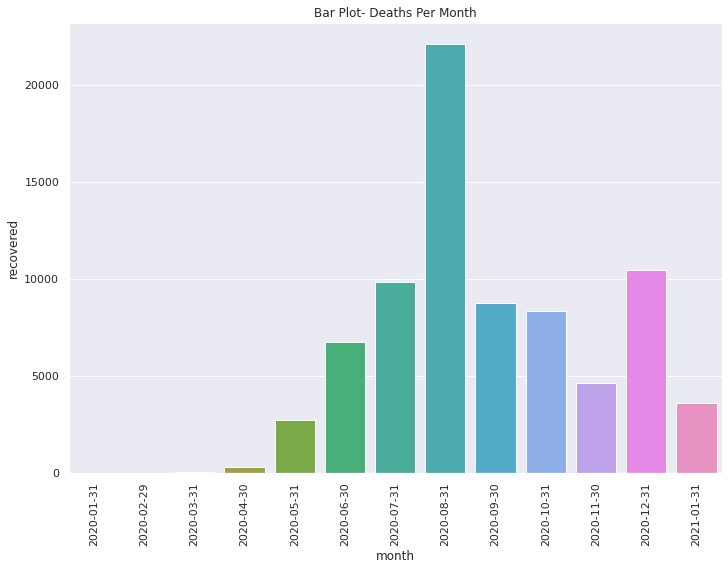

In [29]:
#Number of Recoveries by Month
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='recovered', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## States Data

In [30]:
state_data = load_ntm_data()
state_data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,32687,5100,27337,250
1,FCT,12428,4593,7731,104
2,Kaduna,5555,575,4926,54
3,Plateau,5174,398,4732,44
4,Oyo,4086,618,3416,52


In [31]:
#clean_data
second_data = state_data
affected_column = ['no._of_cases_(lab_confirmed)', 'no._of_cases_(on_admission)','no._discharged']
def polish_data(df):
    clean_columns = df.rename(columns=clean_col)
    # for i in clean_columns.columns:
    #     if i in affected_column:
    #         clean_columns[i] = clean_columns[i].str.replace(',','').astype('int64')
    return clean_columns
cleany = polish_data(second_data)
cleany.head()

,states_affected,no._of_cases_(lab_confirmed),no._of_cases_(on_admission),no._discharged,no._of_deaths
0,Lagos,32687,5100,27337,250
1,FCT,12428,4593,7731,104
2,Kaduna,5555,575,4926,54
3,Plateau,5174,398,4732,44
4,Oyo,4086,618,3416,52


In [32]:
def states_stat(df,st_col, st_death):
    death_by_state =  df[[st_col, st_death]].sort_values(st_death, ascending=False)
    return death_by_state
death_by_states = states_stat(cleany,'states_affected', 'no._of_deaths')


## Deaths By States

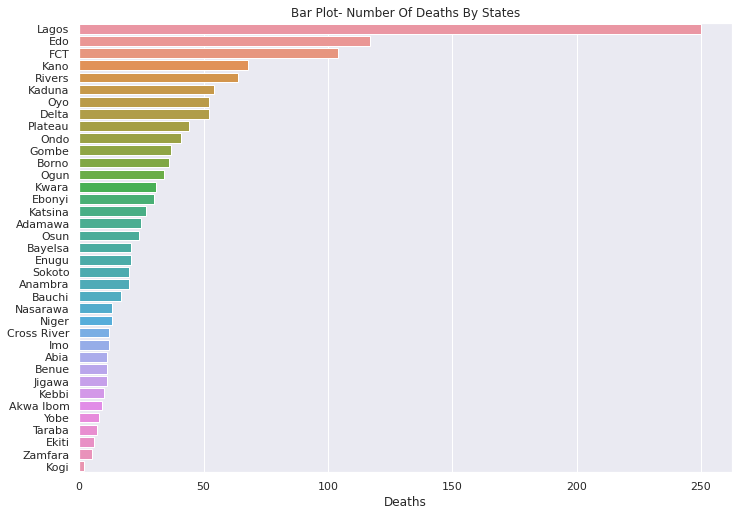

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_deaths', y='states_affected', data=death_by_states)
ax.set_title('Bar Plot- Number Of Deaths By States')
plt.xlabel('Deaths')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recovery Rates By State

In [34]:
def recov_ratio(df, st_col, recov_col, conf_cases, new_col):
  df[new_col] = df[recov_col] / df[conf_cases]
  recovey_ratio = df[[st_col, new_col]].sort_values(new_col, ascending=False)
  return recovey_ratio
state_recov_ratio = recov_ratio(cleany, 'states_affected','no._discharged','no._of_cases_(lab_confirmed)','recov_ratio')
state_recov_ratio.head()

,states_affected,recov_ratio
13,Enugu,0.959859
15,Ebonyi,0.957143
10,Ondo,0.956593
27,Ekiti,0.947242
18,Osun,0.946184


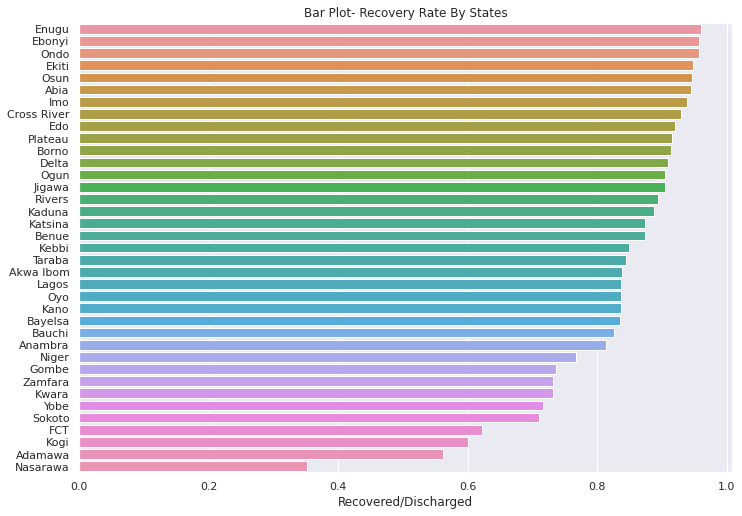

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='recov_ratio', y='states_affected', data=state_recov_ratio)
ax.set_title('Bar Plot- Recovery Rate By States')
plt.xlabel('Recovered/Discharged')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recoveries/Discharged By States

In [36]:
discharged_by_states = states_stat(cleany, 'states_affected', 'no._discharged')


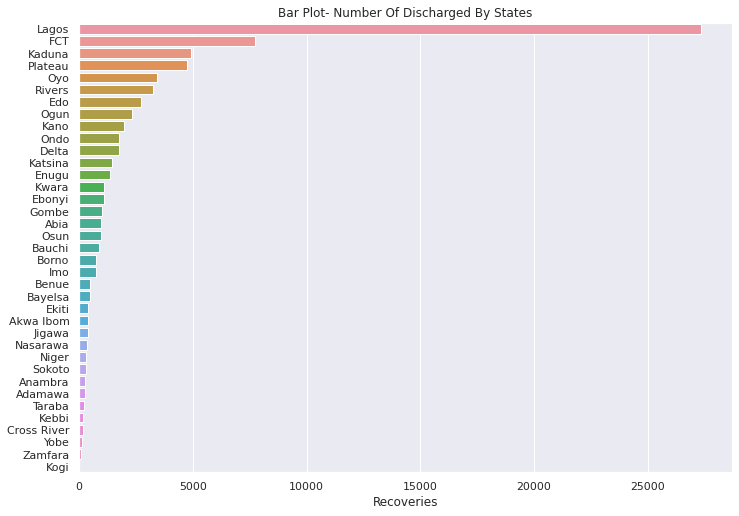

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._discharged',y='states_affected', data=discharged_by_states)
ax.set_title('Bar Plot- Number Of Discharged By States')
plt.xlabel('Recoveries')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## confirmed Cases By States

In [38]:
confirmed_cases_states = states_stat(cleany,'states_affected', 'no._of_cases_(lab_confirmed)')


### Confirmed Cases By States

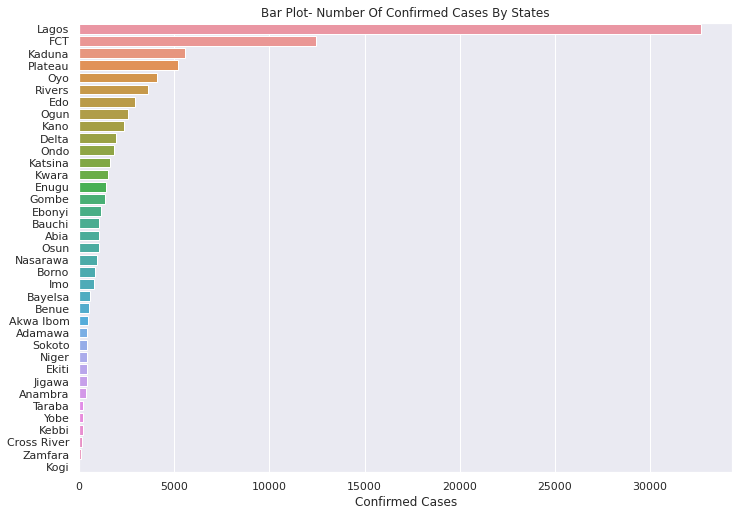

In [39]:
# Confirm cases spread across all states
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_cases_(lab_confirmed)',y='states_affected', data=confirmed_cases_states)
ax.set_title('Bar Plot- Number Of Confirmed Cases By States')
plt.xlabel('Confirmed Cases')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

In [40]:
naija_data.head()

,date,confirmed,deaths,recovered
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


## Race Bar Chart

In [41]:
#get data into shape
#nt_needed = ['deaths','recovered']
def tidyrc_data(df):
    #race_chart_data = df.drop(nt_needed, axis=1)
    clean_rc_data = df.set_index('date')
    return clean_rc_data

clean_rb = tidyrc_data(naija_data)

clean_rb.head()

,confirmed,deaths,recovered
date,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [42]:
bcr.bar_chart_race(clean_rb)

## Build  Logistic Model

### Predicting the Epidemic Situation of Covid19 In Nigeria with Logistic Mathematical Model
My choice of the Logistic Model is simply because it is simple and it conform to the statistical law of Epidemiology

In [43]:
#Preapre data
def clean_model_data(df):
    return df
log_model_data = clean_model_data(naija_data)
log_model_data.tail()

,date,confirmed,deaths,recovered
346,2021-01-02,89163,1302,74789
347,2021-01-03,90080,1311,75044
348,2021-01-04,91351,1318,75699
349,2021-01-05,92705,1319,76396
350,2021-01-06,94369,1324,77299


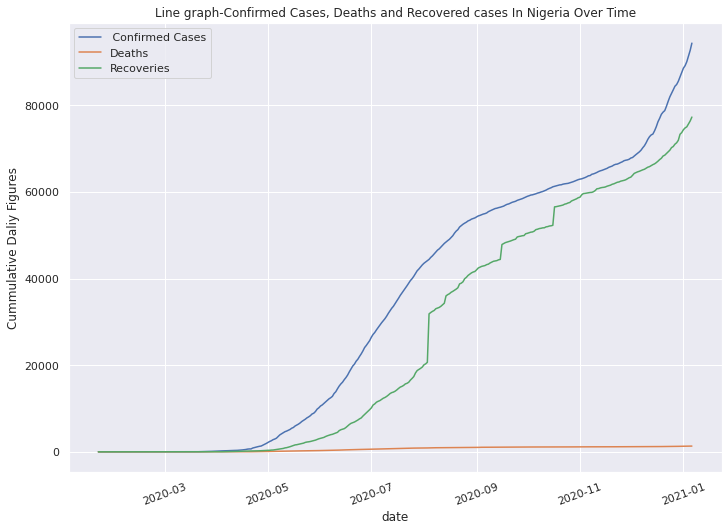

In [44]:
#Line graph of confirm cases over time
ax = sns.lineplot(x='date', y='confirmed', data=log_model_data, label=' Confirmed Cases')
ax = sns.lineplot(x='date', y='deaths', data=log_model_data,label='Deaths')
ax = sns.lineplot(x='date', y='recovered', data=log_model_data, label='Recoveries')
plt.xticks(rotation=20)
ax.set_title('Line graph-Confirmed Cases, Deaths and Recovered cases In Nigeria Over Time')
ax.set_ylabel('Cummulative Daliy Figures')
ax.legend()
plt.show()




## Logistic Model
The logistic model can be simply rendered as $$\huge f(x;a,b,c) = \frac{c}{1 + e^-(x-b)/a}$$ 

where :
- a = **Infection speed**
- b = **Day with maximum Infections Occured**
- c = **Total Number of people that would be infected at the end of the pandemic**

In [45]:
def logistic_model(x,a,b,c,d):
    return a / (1 + np.exp(-c * (x - d))) + b

# def logistics_noise(a,b,c,d,t):
#     return abs(c/(1+a*np.exp(-b*t))+np.random.normal(0,d))

In [46]:
def func_logistic(t,a,b,c):
  return c/(1 + a * np.exp(-b*t))

In [47]:
def build_data(df):
    df['time_stamp'] = df.index
    return df
build_model = build_data(naija_data)
build_model.tail()

,date,confirmed,deaths,recovered,time_stamp
346,2021-01-02,89163,1302,74789,346
347,2021-01-03,90080,1311,75044,347
348,2021-01-04,91351,1318,75699,348
349,2021-01-05,92705,1319,76396,349
350,2021-01-06,94369,1324,77299,350


In [48]:
# extract x(days) & y(cases) from dataframe
# x = list(build_model.iloc[:,4])
# y = list(build_model.iloc[:,1])
x = np.array(build_model['time_stamp']) + 1
y = np.array(build_model['confirmed'])


In [49]:
x

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [50]:
y

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     2,     2,     2,     2,     2,     2,     2,
           2,     3,     8,     8,    12,    22,    30,    40,    44,
          51,    65,    70,    89,   111,   131,   135,   174,   184,
         210,   214,   232,   238,   254,   276,   288,   305,   318,
         323,   343,   373,   407,   442,   493,   542,   627,   665,
         665,   873,   981,  1095,  1182,  1273,  1337,  1532,  1728,
        1932,  2170,  2388,  2558,  2802,  2950,  3145,  3526,  3912,
        4151,  4399,  4641,  4787,  4971,  5162,  5450,  5621,  5959,
        6175,  6401,  6677,  7016,  7261,  7526,  7839,  8068,  8344,
        8733,  8915,

In [51]:
# randomly initialize a,b,c,d
p0 = np.random.exponential(size=3)
p0


array([0.40104235, 1.05197617, 0.24629339])

In [52]:
# set upper and lower bounds a,b,c
bounds = (0,[100000., 1000.,100000000.])
#bounds = ((-np.inf, -np.inf, 0, 0), (np.inf, np.inf, 1, 1))
bounds

(0, [100000.0, 1000.0, 100000000.0])

In [53]:
days_sofar = len(y)
days_sofar

351

In [54]:
(a_, b_, c_), cov = curve_fit(func_logistic,x,y,bounds=bounds, p0=p0, maxfev=1000000)

In [55]:
a_,b_,c_

(190.48683653478344, 0.0280684221134455, 72845.98492452793)

In [56]:
cov

array([[ 7.20064967e+02,  2.15960566e-02, -9.40704960e+03],
       [ 2.15960566e-02,  6.84253909e-07, -3.60888301e-01],
       [-9.40704960e+03, -3.60888301e-01,  4.48069205e+05]])

In [57]:
#the time step at which the growth is fastest
t_fastest = np.log(a_) / b_
print(t_fastest)
i_fastest = func_logistic(days_sofar +10, a_, b_, c_)
i_fastest

187.02807986166215


72298.44215819033

In [58]:
conex = np.array(y)
conex

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     2,     2,     2,     2,     2,     2,     2,
           2,     3,     8,     8,    12,    22,    30,    40,    44,
          51,    65,    70,    89,   111,   131,   135,   174,   184,
         210,   214,   232,   238,   254,   276,   288,   305,   318,
         323,   343,   373,   407,   442,   493,   542,   627,   665,
         665,   873,   981,  1095,  1182,  1273,  1337,  1532,  1728,
        1932,  2170,  2388,  2558,  2802,  2950,  3145,  3526,  3912,
        4151,  4399,  4641,  4787,  4971,  5162,  5450,  5621,  5959,
        6175,  6401,  6677,  7016,  7261,  7526,  7839,  8068,  8344,
        8733,  8915,

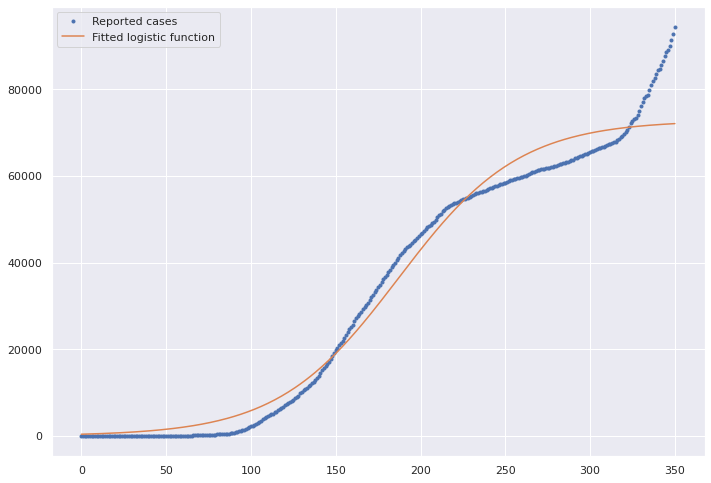

In [59]:
def plot_logistic_fit(confirmed, logistic_params):
    a_, b_, c_ = logistic_params
    x = np.arange(0, len(build_model['time_stamp']))
    plt.plot(x, confirmed, ".", label="Reported cases")
    confirmed_pred = func_logistic(x, a_, b_, c_)
    plt.plot(x, confirmed_pred, label="Fitted logistic function")
    plt.legend()
    plt.show()
    return confirmed_pred
confirmed_pred = plot_logistic_fit(y, (a_, b_, c_))


In [60]:
from sklearn.metrics import r2_score

In [61]:
#check goodness of fit measure
r2_score(y,confirmed_pred)

0.9764906862079928

In [62]:
def plateau(confirmed, logistic_params,diff=1000):
  a_, b_, c_ = logistic_params
  confirm_now = confirmed[-1]
  confirmed_then = confirmed[-2]
  days = 0
  now = x[-1]
  while (confirm_now - confirmed_then) > diff:
    days += 1
    confirm_now = confirmed_then
    confirm_now = func_logistic(now + days, a_, b_, c_)
  return days, confirm_now
days, confirmy = plateau(y,(a_, b_, c_))
days, confirmy

(1, 72142.60402907686)

In [63]:
print(f"last day's case:{y[-1] - y[-2]}")


last day's case:1664


## Focasting with Facebook's Prophet Package
To use this package for logistic growth, a carrying capacity mst be estimated/calculated

In [64]:
# carrying cappacity from above logistic growth model
t_fastest = np.log(a_)/b_
t_fastest

187.02807986166215

In [65]:
check_fastest = func_logistic(t_fastest, a_, b_, c_)
# check_fastest = y[-1] 
check_fastest


36422.99246226397

In [66]:
x[-1]

351

In [67]:
# wrangle dataframe to fit prophet requirement
def forecast_data(df):
  df['ds'] = df['date']
  df['y'] = df['confirmed'] 
  # df['cap'] = check_fastest
  prof_df = df[['ds', 'y']]
  return prof_df
prophet_data =  forecast_data(build_model)
prophet_data.tail()


,ds,y
346,2021-01-02,89163
347,2021-01-03,90080
348,2021-01-04,91351
349,2021-01-05,92705
350,2021-01-06,94369


In [69]:
# prophet_data.tail()

In [70]:
# # different approach
# pr_data_c = build_model.loc[:,['date', 'confirmed']]
# pr_data_c.columns = ['ds', 'y']
# pr_data_c

In [71]:
pd.set_option('display.max_rows', 800)

In [72]:
# #modelling
# m = Prophet()
# m.fit(pr_data_c)
# futurez = m.make_future_dataframe(periods=5)
# forcast_c = m.predict(futurez)
# forcast_c

In [73]:
# #predicting
# confrm = forcast_c.loc[:,['ds','trend']]
# confrm = confrm[confrm['trend']>0]
# confrm = confrm.head(42)
# confrm = confrm.tail(30)
# confrm.columns = ['Date', 'Confirm Count']
# confrm

In [74]:
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# import plotly.offline as py

In [75]:
# fig_conf = plot_plotly(m, forcast_c)
# py.iplot(fig_conf)
# fig_conf = m.plot(forcast_c,xlabel='Date', ylabel='Confirmed Count')



In [76]:
# figure_cf = m.plot_components(forcast_c)

In [77]:
m = Prophet(growth='linear',interval_width=0.95,daily_seasonality=True,weekly_seasonality=True,yearly_seasonality=False, changepoint_prior_scale=0.5,n_changepoints=200,seasonality_mode='multiplicative')
m.fit(prophet_data)
future = m.make_future_dataframe(periods=67, freq='D')


In [78]:
#future['cap'] = prophet_data['cap'].iloc[0]
forecast = m.predict(future)

In [79]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
413,2021-03-10,26651.977880,99763.968195,122853.561558,23954.939086,29383.207711,3.160409,3.160409,3.160409,3.174759,3.174759,3.174759,0.014351,0.014351,0.014351,0.0,0.0,0.0,111265.591541
414,2021-03-11,26746.897349,99302.552657,123241.804612,24003.172767,29553.047590,3.160409,3.160409,3.160409,3.150266,3.150266,3.150266,-0.010142,-0.010142,-0.010142,0.0,0.0,0.0,111006.745781
415,2021-03-12,26841.816818,99209.598612,123898.117076,24052.674156,29719.691868,3.160409,3.160409,3.160409,3.154668,3.154668,3.154668,-0.005741,-0.005741,-0.005741,0.0,0.0,0.0,111518.839343
416,2021-03-13,26936.736287,99733.555211,124278.774337,24097.834473,29884.115338,3.160409,3.160409,3.160409,3.158102,3.158102,3.158102,-0.002307,-0.002307,-0.002307,0.0,0.0,0.0,112005.698855
417,2021-03-14,27031.655756,99907.243239,125434.067770,24107.714164,30055.107704,3.160409,3.160409,3.160409,3.159092,3.159092,3.159092,-0.001317,-0.001317,-0.001317,0.0,0.0,0.0,112427.149199


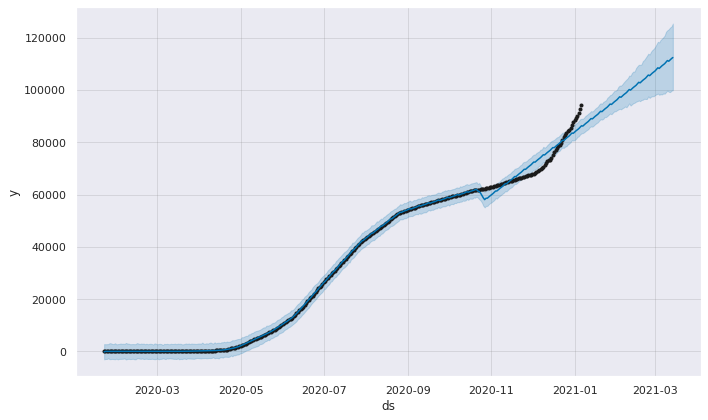

In [80]:
fig = m.plot(forecast)

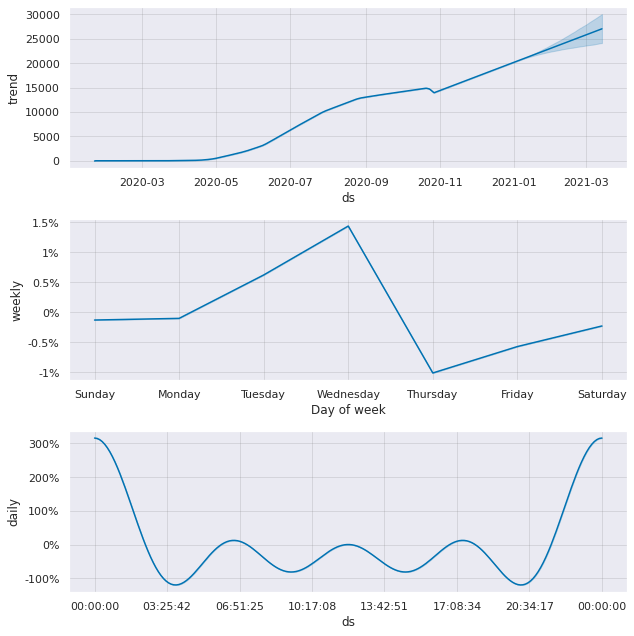

In [82]:
fig2 = m.plot_components(forecast)